# Theoretical Bound vs Numerical Bound

Given we want to solve $\textbf{P}w = b$, where $\textbf{P}$ is the  circulant matrix used in the ParaDiag scheme, given that the linear solve is inexact with a tolerance $\tau$, we have the bound
$$
\left \| \Delta w \right \|_{\infty} \leq \frac{\tau N_t \|B^{-1}\|}{\alpha}\left \| x \right \|_{\infty}
$$
We consider solving a linear equation of the form $\textbf{P}^{-1} Aq = \textbf{P}^{-1}c$. Then, using modified Richardson iterations, we are essentially solving for 
$$
\textbf{P}w = (c - \textbf{A}q) = b
$$
In the ParaDiag case for the scalar advection equation, we have the expression 
$$
\textbf{A}\textbf{q} = \left(\frac{1}{\Delta t}\textbf{B}_{1}\otimes\textbf{M} + \textbf{B}_{2}\otimes\textbf{K}\right)\textbf{q}
$$
The right hand side vector $\textbf{c}$ contains the initial condition:

$$
\begin{pmatrix}
q^{0}/\Delta t - (1-\theta)\textbf{K}q^{0} \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$

We analyse only the first iteration. Then, the inner solve becomes 
$$
Pw = (c - \textbf{A}q_{inital})
$$

To start, we set up the all-at-once matrix $\textbf{A}$.

In [265]:
from math import pi
import numpy as np

nt = 128
nx = 128

lx = 2*pi
dx = lx/nx

theta = 0.55

# velocity, CFL, and reynolds number
u = 1
re = 500
cfl = 0.8

# viscosity and timestep
nu = 0 #lx*u/re
dt = cfl*dx/u

# advective and diffusive Courant numbers

cfl_u = cfl
cfl_v = nu*dt/dx**2

print(f"{nu = }, {dt = }, {cfl_v = }, {cfl_u = }")

# Spatial domain
mesh = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

nu = 0, dt = 0.039269908169872414, cfl_v = 0.0, cfl_u = 0.8


In [266]:
from scipy import sparse
from scipy import linalg
from scipy.sparse import linalg as spla

# Finite difference spatial discretisations                                                                                                                                                   
def gradient_stencil(grad, order):                                                                                                                                                            
    '''                                                                                                                                                                                       
    Return the centred stencil for the `grad`-th gradient                                                                                                                                     
    of order of accuracy `order`                                                                                                                                                              
    '''                                                                                                                                                                                       
    return {                                                                                                                                                                                  
        1: {  # first gradient                                                                                                                                                                
            2: np.array([-1/2, 0, 1/2]),                                                                                                                                                      
            4: np.array([1/12, -2/3, 0, 2/3, -1/12]),                                                                                                                                         
            6: np.array([-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60])                                                                                                                             
        },                                                                                                                                                                                    
        2: {  # second gradient                                                                                                                                                               
            2: np.array([1, -2, 1]),                                                                                                                                                          
            4: np.array([-1/12, 4/3, -5/2, 4/3, -1/12]),                                                                                                                                      
            6: np.array([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90])                                                                                                                         
        },                                                                                                                                                                                    
        4: {  # fourth gradient                                                                                                                                                               
            2: np.array([1,  -4, 6, -4, 1]),                                                                                                                                                  
            4: np.array([-1/6, 2, -13/2, 28/3, -13/2, 2, -1/6]),                                                                                                                              
            6: np.array([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240])  # noqa: E501                                                                                     
        }                                                                                                                                                                                     
    }[grad][order]                                                                                                                                                                            
                                                                                                                                                                                              
                                                                                                                                                                                              
def sparse_circulant(stencil, n):                                                                                                                                                             
    '''                                                                                                                                                                                       
    Return sparse scipy matrix from finite difference                                                                                                                                         
    stencil on a periodic grid of size n.                                                                                                                                                     
    '''                                                                                                                                                                                       
    if len(stencil) == 1:                                                                                                                                                                     
        return sparse.spdiags([stencil[0]*np.ones(n)], 0)                                                                                                                                     
                                                                                                                                                                                              
    # extend stencil to include periodic overlaps                                                                                                                                             
    ns = len(stencil)                                                                                                                                                                         
    noff = (ns-1)//2                                                                                                                                                                          
    pstencil = np.zeros(ns+2*noff)                                                                                                                                                            
                                                                                                                                                                                              
    pstencil[noff:-noff] = stencil                                                                                                                                                            
    pstencil[:noff] = stencil[noff+1:]                                                                                                                                                        
    pstencil[-noff:] = stencil[:noff]                                                                                                                                                         
                                                                                                                                                                                              
    # constant diagonals of stencil entries                                                                                                                                                   
    pdiags = np.tile(pstencil[:, np.newaxis], n)                                                                                                                                              
                                                                                                                                                                                              
    # offsets for inner domain and periodic overlaps                                                                                                                                          
    offsets = np.zeros_like(pstencil, dtype=int)                                                                                                                                              
                                                                                                                                                                                              
    offsets[:noff] = [-n+1+i for i in range(noff)]                                                                                                                                            
    offsets[noff:-noff] = [-noff+i for i in range(2*noff+1)]                                                                                                                                  
    offsets[-noff:] = [n-noff+i for i in range(noff)]                                                                                                                                         
                                                                                                                                                                                              
    return sparse.spdiags(pdiags, offsets)

In [267]:
# Mass matrix                                                                                                                                                                                 
M = sparse_circulant([1], nx)                                                                                                                                                                 
                                                                                                                                                                                              
# Advection matrix                                                                                                                                                                            
D = sparse_circulant(gradient_stencil(1, order=2), nx)                                                                                                                                        
                                                                                                                                                                                              
# Diffusion matrix                                                                                                                                                                            
L = sparse_circulant(gradient_stencil(2, order=2), nx)

# Spatial terms                                                                                                                                                                               
K = (u/dx)*D - (nu/dx**2)*L

# Generate block matrices for different coefficients                                                                                                                                          
def block_matrix(l1, l2):                                                                                                                                                                     
    mat = l1*M + l2*K                                                                                                                                                                         
    mat.solve = spla.factorized(mat.tocsc())                                                                                                                                                  
    return mat

In [268]:
# Build the full B1 & B2 matrices
b1col = np.zeros(nt)
b1col[0] = 1/dt
b1col[1] = -1/dt

b1row = np.zeros_like(b1col)
b1row[0] = b1col[0]

b2col = np.zeros(nt)
b2col[0] = theta
b2col[1] = 1-theta

b2row = np.zeros_like(b2col)
b2row[0] = b2col[0]

B1 = linalg.toeplitz(b1col, b1row)                                                                                                                                                            
B2 = linalg.toeplitz(b2col, b2row)

# Build the A0 and A1 matrices
A1 = block_matrix(b1col[0], b2col[0])
A0 = block_matrix(b1col[1], b2col[1])

# Now build the full Jacobian A
A = spla.aslinearoperator(sparse.kron(B1, M) + sparse.kron(B2, K))

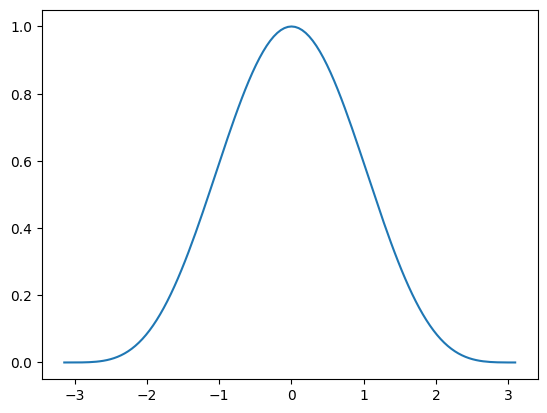

In [269]:
from math import pi

qinit = np.zeros_like(mesh)
qinit[:] = np.cos(mesh/2)**4

# set up timeseries                                                                                                                                                                           
q = np.zeros(nt*nx)                                                                                                                                                                           
rhs = np.ones_like(q)                                                                                                                                                                        
                                                                                                                                                                                              
q = q.reshape((nt, nx))                                                                                                                                                                       
rhs = rhs.reshape((nt, nx))                                                                                                                                                                   
                                                                                                                                                                                              
# initial guess is constant solution                                                                                                                                                          
q[:] = qinit[np.newaxis, :]                                                                                                                                                                   
rhs[0] -= A0.dot(qinit)                                                                                                                                                                       
                                                                                                                                                                                              
q = q.reshape(nx*nt)
rhs = rhs.reshape(nx*nt)

import matplotlib.pyplot as plt
plt.plot(mesh, qinit)
plt.show()

We first consider a block diagonal matrix of the form $\textbf{B} = \operatorname{diag}(B_1, B_2, \ldots, B_n)$. Letting $\textbf{y} = (y_1, y_2, \ldots, y_n)^{T}$, if we solve an equation of the form $\textbf{B}\textbf{x} = \textbf{y}$, we have that 
$$
\textbf{x} = (B_1^{-1}y_1, B_2^{-1}y_2, \ldots, B_n^{-1}y_n)

We now set up the preconditioner $\textbf{P}$. We construct the ``BlockCirculantLinearOperatorExact`` class, which will implement the inner solve exactly, and the ``BlockCirculantLinearOperatorInexact`` class, which will implement the inner solve inexactly up to a relative tolerance ``tol``, using GMRES iterations.

In [270]:
from scipy.fft import fft, ifft

class BlockCirculantLinearOperatorExact(spla.LinearOperator):
    def __init__(self, b1col, b2col, block_matrix, nx, alpha=1):
        self.nt = len(b1col)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1col.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1col*self.gamma, norm='backward')
        eigvals2 = fft(b2col*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_matrix(l1, l2)
                             for l1, l2 in eigvals))

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v):
        for i in range(self.nt):
            v[i] = self.blocks[i].solve(v[i])
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y = self._block_solve(y)
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

In [271]:
from scipy.fft import fft, ifft

tol = 0.001
class BlockCirculantLinearOperatorInexact(spla.LinearOperator):
    def __init__(self, b1col, b2col, block_matrix, nx, alpha=1):
        self.nt = len(b1col)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1col.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1col*self.gamma, norm='backward')
        eigvals2 = fft(b2col*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_matrix(l1, l2)
                             for l1, l2 in eigvals))
        
        self.global_tol = None

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v): # method for inexact block solve
        for i in range(self.nt):
            vi = v[i]
            vi_approx, exit_code = spla.gmres(self.blocks[i], vi, rtol=tol)
            v[i] = vi_approx
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y_exact = y.copy()
         # compute the exact inner solve for each block
        y = self._block_solve(y) # compute inexact solve for each block
        res_blocks = []
        for i in range(self.nt):
            res_blocks.append(self.blocks[i].dot(y[i]) - y_exact[i])
        res = np.vstack(res_blocks)
        rel_res = np.linalg.norm(res, np.inf) / np.linalg.norm(y_exact, np.inf)
        self.global_tol = rel_res
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

In [219]:
alpha = 1e-3
P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

b = rhs - A*q
exact_solve = P_exact * b
inexact_solve = P_inexact * b

print(f"error norm: {np.linalg.norm(exact_solve - inexact_solve, np.inf)}")

error norm: 0.018887176662287786


In [188]:
from scipy.sparse import issparse
import numpy as np
print('global tol:', P_inexact.global_tol)
global_tol = P_inexact.global_tol
# compute inf norm of B^{-1} by taking the max norm of the block inverses
max_norm = 0
for Bi in P_inexact.blocks:
    Bi_lu = spla.splu(Bi.tocsc())        
    I = np.eye(Bi.shape[0])         
    B_inv = Bi_lu.solve(I)          
    norm = np.linalg.norm(B_inv, np.inf)
    if norm >= max_norm:
        max_norm = norm

print("Theoretical bound:", global_tol * nt * max_norm/alpha * np.linalg.norm(b, np.inf))
print("Numerical bound:", np.linalg.norm(exact_solve - inexact_solve, np.inf))

global tol: 0.0001042961644701054
Theoretical bound: 17.161464960417863
Numerical bound: 0.018887176662287786


We now set up random right hand side vector.

In [189]:
np.random.seed(583)

vec_len = len(b)
b_rand = np.random.rand(vec_len)
b_rand /= np.linalg.norm(b_rand, np.inf)

P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

exact_solve = P_exact * b_rand
inexact_solve = P_inexact * b_rand

global_tol = P_inexact.global_tol
print(global_tol)
print("Theoretical bound:", global_tol * nt * max_norm/alpha)
print("Numerical bound:", np.linalg.norm(exact_solve - inexact_solve, np.inf))

0.0007728495323752948
Theoretical bound: 77.12611064279132
Numerical bound: 0.03467051745790739


In [113]:
ratios = []
for i in range(200):

    np.random.seed(i)
    vec_len = len(b)
    b_rand = np.random.rand(vec_len)
    b_rand /= np.linalg.norm(b_rand, np.inf)

    P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
    P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

    exact_solve = P_exact * b_rand
    inexact_solve = P_inexact * b_rand

    global_tol = P_inexact.global_tol
    theoretical_bound = global_tol * nt * max_norm/alpha
    numerical_bound = np.linalg.norm(exact_solve - inexact_solve, np.inf)
    ratios.append(theoretical_bound/numerical_bound)


KeyboardInterrupt: 

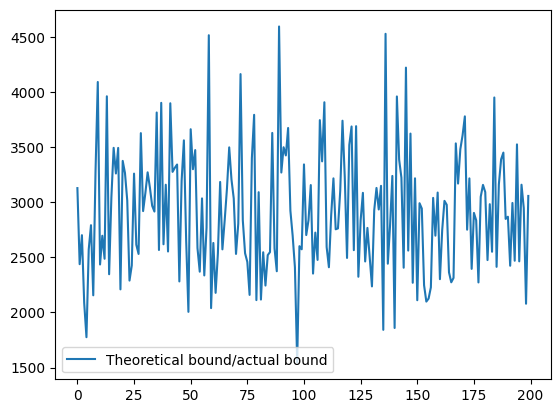

In [52]:
plt.plot(ratios, label="Theoretical bound/actual bound")
plt.legend()

In [99]:
print("Mean ratio:", sum(ratios)/len(ratios))

Mean ratio: 1085.8689537430982


In [272]:
alpha_range = np.linspace(1e-1, 1e-6, 500)
vec_len = 128 * nx
b_rand = np.random.rand(vec_len)
b_rand /= np.linalg.norm(b_rand, np.inf)
numericals = []
test = []
xs = []
taus = []
b_invs = []
ys = []

for i in alpha_range:
    alpha = i 
    P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
    P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

    b = b_rand
    exact_solve = P_exact * b
    inexact_solve = P_inexact * b
    check_tol = P_inexact.global_tol
    numericals.append(np.linalg.norm(exact_solve - inexact_solve, np.inf))
    max_norm = 0
    for Bi in P_inexact.blocks:
        Bi_lu = spla.splu(Bi.tocsc())        
        I = np.eye(Bi.shape[0])         
        B_inv = Bi_lu.solve(I)          
        norm = np.linalg.norm(B_inv, np.inf)
        if norm >= max_norm:
            max_norm = norm
    
    test.append(check_tol * nt * max_norm/alpha)
    xs.append(check_tol)
    taus.append(check_tol)
    b_invs.append(max_norm)
    ys.append(np.linalg.norm(exact_solve - inexact_solve, np.inf))#/check_tol)


We try the more tight bound

$$
\|A\|\|C\| \leq \alpha^{-(N_t - 1)/N_t}N_t
$$
Then, we get the bound 

$$
\|\Delta w\| \leq  \tau\alpha^{-(N_t - 1)/N_t}N_t \|B^{-1}\| \|x\|

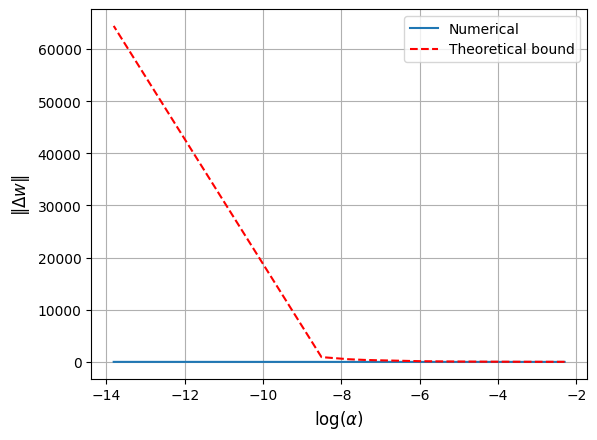

In [274]:
fig, ax = plt.subplots()
y_bound = np.array(taus) * nt * np.array(alpha_range)**(-(nt-1)/nt) / (1 - np.array(alpha_range)**(1/nt))
B_inv_block_bound = 1 / (1 - np.array(alpha_range)**(1/nt))

# Tight Δw bound
y_bound_tight = np.array(taus) * nt * B_inv_block_bound
delta_w_bound = np.zeros_like(alpha_range)

for i, alpha in enumerate(alpha_range):
    # Compute the exact geometric sum factor for V and V^-1
    geometric_sum = (1 - alpha) / (1 - alpha**(1/nt))
    
    # B^-1 block bound
    B_inv_bound = 1 / (1 - alpha**(1/nt))
    
    # Combine factors: ||Delta w|| <= tau * ||V|| * ||B^-1|| * ||V^-1|| * ||r||
    delta_w_bound[i] = taus[i] * (geometric_sum * B_inv_bound * geometric_sum)

ax.plot(np.log(alpha_range), ys, label='Numerical')
ax.plot(np.log(alpha_range), bounds_tight_exact, 'r--', label='Theoretical bound')
ax.set_xlabel(r'$\log(\alpha)$', fontsize=12)
ax.set_ylabel(r'$\|\Delta w\|$', fontsize=12)
ax.legend()
ax.grid(True)




In [231]:
x_ax = nt/(np.array(alpha_range)*(1 - np.array(alpha_range)**(1/nt)))
x_ax_tight = np.array(alpha_range)**(-(nt -1)/nt) * nt * (1/(1 - np.array(alpha_range)**(1/nt)))

min((x_ax - np.array(ys)))

np.float64(71789.23878624206)

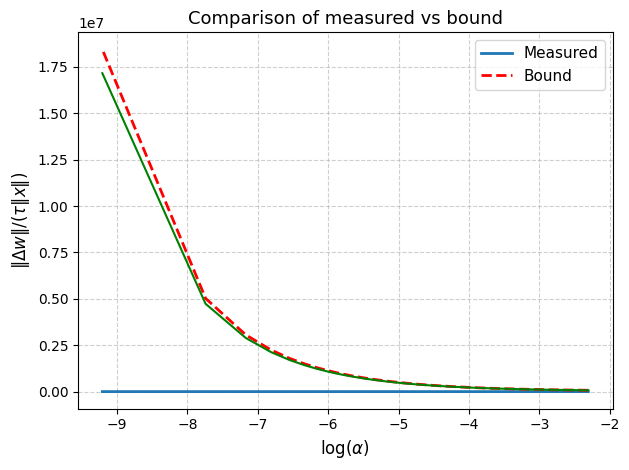

In [229]:
fig, ax = plt.subplots()
ax.plot(np.log(alpha_range)[:], ys[:], label="Measured", lw=2)
ax.plot(np.log(alpha_range)[:], x_ax[:], 'r--', label="Bound", lw=2)
ax.plot(np.log(alpha_range), x_ax_tight, color='g')

ax.set_xlabel(r"$\log(\alpha)$", fontsize=12)
ax.set_ylabel(r"$\|\Delta w\| / (\tau \|x\|)$", fontsize=12)
ax.set_title("Comparison of measured vs bound", fontsize=13)

# Grid, legend, and nice ticks
ax.grid(True, which="both", linestyle="--", alpha=0.6)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

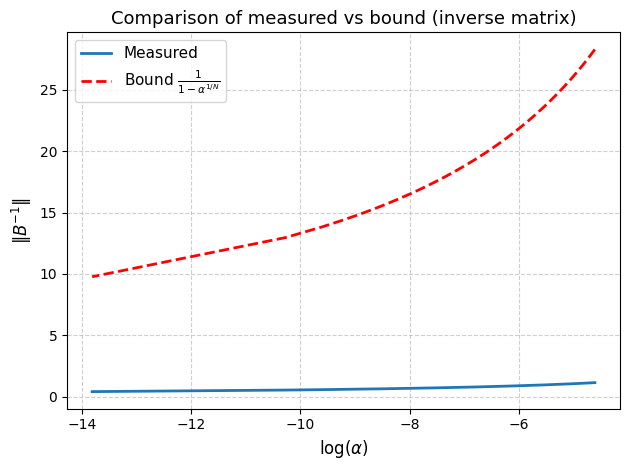

In [202]:
theory_b_inv = 1/(1 - np.array(alpha_range)**(1/nt))

fig, ax = plt.subplots()
ax.plot(np.log(alpha_range)[:], b_invs[:], label="Measured", lw=2)
ax.plot(np.log(alpha_range)[:], theory_b_inv[:], 'r--', label=r"Bound $\frac{1}{1-\alpha^{1/N}}$", lw=2)

ax.set_xlabel(r"$\log(\alpha)$", fontsize=12)
ax.set_ylabel(r"$\|B^{-1}\|$", fontsize=12)
ax.set_title("Comparison of measured vs bound (inverse matrix)", fontsize=13)

# Grid, legend, and nice ticks
ax.grid(True, which="both", linestyle="--", alpha=0.6)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


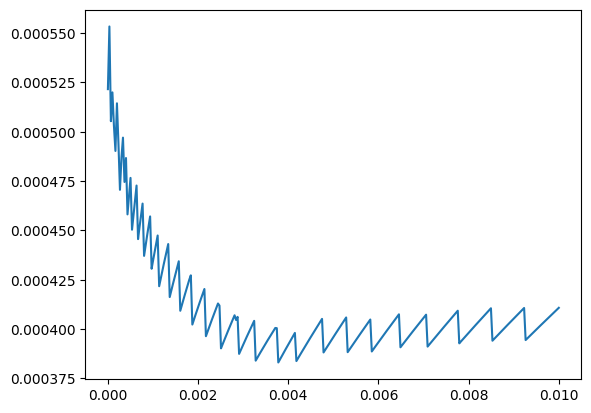

In [154]:
plt.plot(alpha_range, taus)

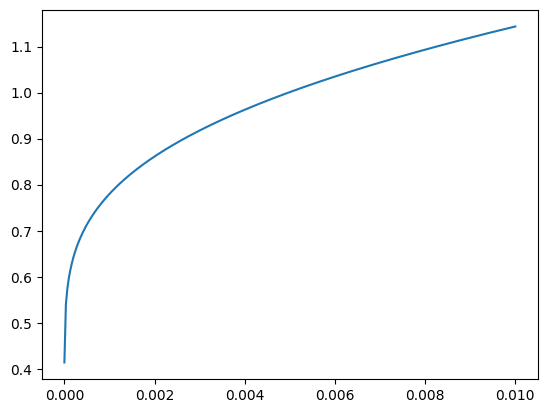

In [155]:
plt.plot(alpha_range, b_invs)

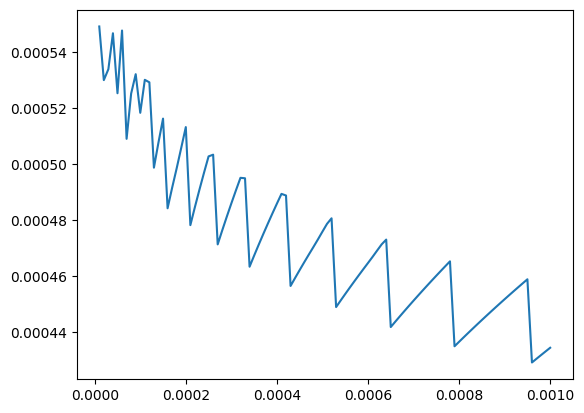

In [148]:
plt.plot(alpha_range, xs)

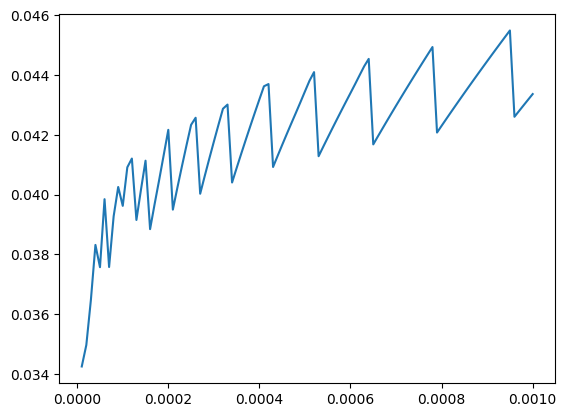

In [152]:
plt.plot(alpha_range, test * np.array(alpha_range))
#plt.plot(alpha_range, 1/np.array(alpha_range), color='r')

We now numerically test the bound 
$$
\left\| \Delta w \right \| \leq \frac{\tau N}{\alpha(1 - \alpha^{\frac{1}{N}})}\|x\|
$$

In [139]:
np.random.seed(583)
alpha = 1e-2
vec_len = len(b)
b_rand = np.random.rand(vec_len)
b_rand /= np.linalg.norm(b_rand, np.inf)

P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

exact_solve = P_exact * b_rand
inexact_solve = P_inexact * b_rand
global_tol = P_inexact.global_tol

print(f"Theoretical bound (derived): {global_tol * nt/(alpha * (1 - alpha ** (1/nt)))}")
print(f"Numerical bound: {np.linalg.norm(exact_solve - inexact_solve, np.inf)}")

Theoretical bound (derived): 148.79117754666962
Numerical bound: 0.0203153873276829


We also check the tightness of the bound 
$$
\left\| \hat{B}^{-1} \right\|_{\infty} \leq \frac{1}{1-\alpha^{\frac{1}{N}}}
$$

In [140]:
max_norm = 0
for Bi in P_inexact.blocks:
        Bi_lu = spla.splu(Bi.tocsc())        
        I = np.eye(Bi.shape[0])         
        B_inv = Bi_lu.solve(I)          
        norm = np.linalg.norm(B_inv, np.inf)
        if norm >= max_norm:
            max_norm = norm

print(f"Norm: {max_norm}, Bound: {1/(1 - alpha**(1/nt))}")

Norm: 1.1436611172772113, Bound: 28.29784493480262


In [141]:
# 1.1432968801677317

In [276]:
np.random.seed(583)
nt = 32
alpha = 1e-3
nts = []
tols = []
errs = []
b_inv_norms = []

for i in range(5):
    vec_len = nt * nx
    b_rand = np.random.rand(vec_len)
    b_rand /= np.linalg.norm(b_rand, np.inf)
    b1col = np.zeros(nt)
    b1col[0] = 1/dt
    b1col[1] = -1/dt

    b1row = np.zeros_like(b1col)
    b1row[0] = b1col[0]

    b2col = np.zeros(nt)
    b2col[0] = theta
    b2col[1] = 1-theta

    b2row = np.zeros_like(b2col)
    b2row[0] = b2col[0]

    P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
    P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

    exact_solve = P_exact * b_rand
    inexact_solve = P_inexact * b_rand

    max_norm = 0
    for Bi in P_inexact.blocks:
        Bi_lu = spla.splu(Bi.tocsc())        
        I = np.eye(Bi.shape[0])         
        B_inv = Bi_lu.solve(I)          
        norm = np.linalg.norm(B_inv, np.inf)
        if norm >= max_norm:
            max_norm = norm
    b_inv_norms.append(max_norm)
    global_tol = P_inexact.global_tol
    tols.append(global_tol)
    errs.append(np.linalg.norm(exact_solve - inexact_solve, np.inf))
    nts.append(nt)
    nt *= 2

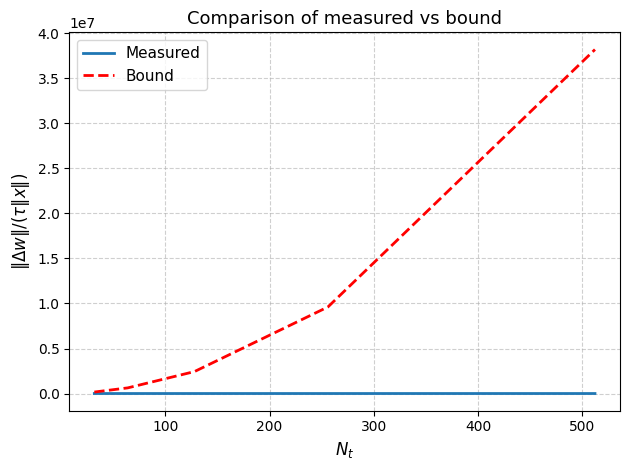

In [277]:
fig, ax = plt.subplots()
errs_array = np.array(errs)
tols_array = np.array(tols)
nts_array = np.array(nts)
ax.plot(nts, errs_array/tols_array, label='Measured', lw=2)
ax.plot(nts, nts_array/(alpha * (1-alpha**(1/nts_array))), 'r--', label='Bound', lw=2)

ax.set_xlabel(r"$N_t$", fontsize=12)
ax.set_ylabel(r"$\|\Delta w\| / (\tau \|x\|)$", fontsize=12)
ax.set_title("Comparison of measured vs bound", fontsize=13)

# Grid, legend, and nice ticks
ax.grid(True, which="both", linestyle="--", alpha=0.6)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


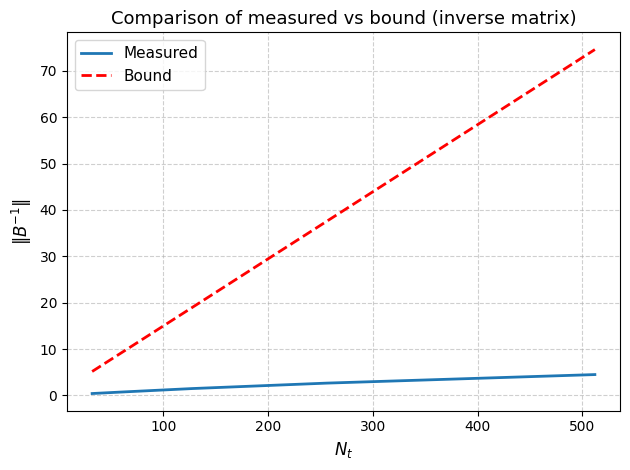

In [283]:
fig, ax = plt.subplots()
errs_array = np.array(errs)
tols_array = np.array(tols)
nts_array = np.array(nts)
norms_array = np.array(b_inv_norms)
ax.plot(nts, norms_array, label='Measured', lw=2)
ax.plot(nts, 1/(1-alpha**(1/nts_array)), 'r--', label='Bound', lw=2)

ax.set_xlabel(r"$N_t$", fontsize=12)
ax.set_ylabel(r"$\|B^{-1}\|$", fontsize=12)
ax.set_title("Comparison of measured vs bound (inverse matrix)", fontsize=13)

# Grid, legend, and nice ticks
ax.grid(True, which="both", linestyle="--", alpha=0.6)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

In [300]:
arr1 = np.array([i for i in range(5)])
arr2 = np.array([i for i in range(5)])
arr1.sum()

np.int64(10)

In [262]:
import numpy as np
from scipy.fft import fft, ifft

Nt = 128
VV_1 = []
for alpha in alpha_range:

    # Construct Gamma and Gamma^-1
    gamma = alpha**(np.arange(Nt)/Nt)
    Gamma = np.diag(gamma)
    Gamma_inv = np.diag(1/gamma)

    # Construct unitary FFT matrix (normalized)
    F = fft(np.eye(Nt)) / np.sqrt(Nt)
    F_star = np.conj(F.T)

    # V and V^-1
    V = Gamma_inv @ F_star
    V_inv = F @ Gamma

    # Infinity norms
    norm_V = np.linalg.norm(V, np.inf)
    norm_V_inv = np.linalg.norm(V_inv, np.inf)
    VV_1.append(norm_V * norm_V_inv)

print("||V||_inf =", norm_V)
print("||V^-1||_inf =", norm_V_inv)
print("Product =", norm_V * norm_V_inv)
print("Bound:", Nt/alpha)
print("Product/Bound", (norm_V * norm_V_inv)/(Nt/alpha))

||V||_inf = 10156170.539798439
||V^-1||_inf = 0.8639016907082135
Product = 8773932.90045282
Bound: 128000000.0
Product/Bound 0.06854635078478766


In [263]:
VV_1_array = np.array(VV_1)
bounds_tight_exact = VV_1_array * np.array(taus) * (1/(1-np.array(alpha_range)**(1/nt)))
 